# Test the effect of life cycle, RNAi and GC content on TE evolution, Fig 4
**Objective**: Test if the factors *mating system*, *parasitism*, *RNAi pathways* and if the variance in *GC content* explain the variance in TE loads.   
  
**Inputs**:  

+ The pickled `Project`: `'TE_counts/18S_tree_reprophylo_project_with_TE'`
+ The life cycle info: `18S_tree/data/lifestyle.csv`
+ RNAi info: `silencing/pathways`
+ Trees file: `18S_tree/phylobayes/822861429729532.25_18S@SINAR@gappyout.1.treelist`
 
**Outputs**:

+ `independent_contrasts/Anova_pvalues.pkl`
+ `independent_contrasts/Corr_pvalues.pkl`
+ NHX formated `.tre` files in `independent_contrasts/anc` for each class.
+ `.png` file for each class in `independent_contrasts/anc`, showing change magnitude in ancestral states.  
  
**Strategy**:  
  
+ Anova test of categorial effects on phylogenetically independent contrasts  
+ Corrolation between GC content ancestral states and TE loads ancestral states
+ Compute trait change in ancestral nodes

In [1]:
import os
from reprophylo import *
import TE

if not os.path.exists('independent_contrasts'):
    os.mkdir('independent_contrasts')

## Load life cycle and RNAi info onto the ReproPhylo Project
###Life cycel info
Including parasitism and mating system. The character states will be assigned to feature qualifiers in the `Project.records` list.

In [2]:
pj = unpickle_pj('TE_counts/18S_tree_reprophylo_project_with_TE', git=False)

# A list of species codes
expected_codes = TE.genome_codes_list('Genomes/',code_file='genome_assembly_files_v3.csv')
if len(expected_codes) == 0:
    raise IOError('could not read expected codes')

# Parse the lifstyle table
lstyle = open('18S_tree/data/lifestyle.csv','r').readlines()

fields = lstyle[0].rstrip().split('\t')
fields[-1] = 'Lstyle_refs'

from itertools import chain

# Put the mating system and parasitism
# character states as feature
# qualifiers
for f in chain(*[r.features for r in pj.records]):
    if 'keep' in f.qualifiers.keys():
        code = f.qualifiers['keep'][0]
        style=None
        try:
            style = [l.rstrip().split('\t') for l in lstyle[1:] if
                     l.startswith('%s\t'%code)][0]
        except:
            print 'skipping %s'%code
        if style:
            expected_codes.remove(code)
            for i in range(2,11):
                f.qualifiers[fields[i]] = [style[i]]
                
if len(expected_codes) > 0:
    warnings.warn('could not find lifestyle for %s'%str(expected_codes))
            
# Species that were skipped because they are excluded:

DEBUG:Cloud:Log file (/root/.picloud/cloud.log) opened


skipping Acal
skipping Dpul
skipping Alyr
skipping Nve
skipping Ath
skipping Vcar
skipping Nvi


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:34: UserWarning: could not find lifestyle for ['Eela', 'Ooch']


In [3]:
# Save the changes Project
pickle_pj(pj, 'independent_contrasts/18S_tree_reprophylo_project_with_TE_and style')

'independent_contrasts/18S_tree_reprophylo_project_with_TE_and style'

In [5]:
# Load it the next day
from reprophylo import *
pj = unpickle_pj('independent_contrasts/18S_tree_reprophylo_project_with_TE_and style', git=False)

### RNAi info

In [4]:
import TE

# list species codes
expected_codes = TE.genome_codes_list('Genomes/',code_file='genome_assembly_files_v3.csv')
if len(expected_codes) == 0:
    raise IOError('could not read expected codes')

# Parse the RNAi info table
rnailines = open('silencing/pathways','r').readlines()

fields = rnailines[0].rstrip().split('\t')

from itertools import chain

# Put the persence absence of RNAi proteins as feature
# qualifiers
for f in chain(*[r.features for r in pj.records]):
    if 'keep' in f.qualifiers.keys():
        code = f.qualifiers['keep'][0]
        rnail=None
        try:
            rnail = [l.rstrip().split('\t') for l in rnailines[1:] if
                     l.startswith('%s\t'%code)][0]
        except:
            print 'skipping %s'%code
        if rnail:
            expected_codes.remove(code)
            for i in range(3,6):
                f.qualifiers[fields[i]] = [rnail[i]]
                
if len(expected_codes) > 0:
    warnings.warn('could not find RNAi for %s'%str(expected_codes))
            
# Species that were skipped because they are excluded:

skipping Acal
skipping Dpul
skipping Alyr
skipping Nve
skipping Ath
skipping Vcar
skipping Nvi


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:32: UserWarning: could not find RNAi for ['Eela', 'Ooch']


In [5]:
pickle_pj(pj, 'independent_contrasts/18S_tree_reprophylo_project_with_TE_style_and_RNAi')

'independent_contrasts/18S_tree_reprophylo_project_with_TE_style_and_RNAi'

### Classify presence absence of RNAi proteins into groups
In addition to the presence and absence of RNAi proteins, I want to classify a given composition of proteins into one of several pathways:

In [6]:
coding = {'CladeI_rnai': ['rrf3'],
          'CladeIII_rnai': ['rrf1','rrf3'],
          'Tylenchoidea_rnai': ['rrf1'],
          'Outgroup_rnai': ['piwi'],
          'CladeV_rnai': ['piwi','rrf1','rrf3'],
          'singleton_rnai': ['piwi','rrf1']
          }

# Now put the "pathway" name as a qualifier in 
# the record features.
for r in pj.records:
    feature = r.features[1]
    qual = feature.qualifiers
    codeit = False
    if any(['rrf1' in qual.keys(),
            'rrf3' in qual.keys(),
            'piwi' in qual.keys()]):
        codeit = True
    
    if codeit:
        rnai_code = None
        found = []
        for orth in ['piwi','rrf1','rrf3']:
            if orth in qual.keys() and int(qual[orth][0]) == 1:
                found.append(orth)
        print  found       
        for c in coding:
            if sorted(found) == sorted(coding[c]):
                rnai_code = c
                feature.qualifiers['RNAi'] = [rnai_code]
        if not rnai_code:
            print 'no code for combination %s'%str(orth)
            
# Save the Project with all the metadata.
pickle_pj(pj, 'independent_contrasts/18S_tree_reprophylo_project_with_TE_style_and_RNAi')

['rrf1']
['piwi', 'rrf1', 'rrf3']
['rrf1']
['piwi', 'rrf1', 'rrf3']
['rrf1']
['rrf1', 'rrf3']
['piwi', 'rrf1', 'rrf3']
['piwi', 'rrf1']
['rrf1', 'rrf3']
['rrf1']
['piwi', 'rrf1', 'rrf3']
['rrf3']
['rrf1']
['rrf1']
['piwi', 'rrf1', 'rrf3']
['rrf1']
['rrf3']
['rrf1']
['piwi', 'rrf1', 'rrf3']
['rrf3']
['rrf1', 'rrf3']
['rrf1', 'rrf3']
['rrf1', 'rrf3']
['rrf1']
['rrf1']
['piwi', 'rrf1', 'rrf3']
['rrf1', 'rrf3']
['rrf1']
['rrf1', 'rrf3']
['piwi', 'rrf1', 'rrf3']
['rrf1', 'rrf3']
['piwi', 'rrf1', 'rrf3']
['rrf1', 'rrf3']
['piwi', 'rrf1', 'rrf3']
['rrf1', 'rrf3']
['rrf3']
['rrf1', 'rrf3']
['rrf1', 'rrf3']
['piwi', 'rrf1', 'rrf3']
['rrf1']
['piwi', 'rrf1', 'rrf3']
['rrf3']
['piwi', 'rrf1', 'rrf3']
['rrf3']
['piwi']
['rrf1']
['rrf1', 'rrf3']
['rrf1', 'rrf3']
['rrf1', 'rrf3']
['piwi', 'rrf1', 'rrf3']
['rrf1', 'rrf3']
['rrf1', 'rrf3']


'independent_contrasts/18S_tree_reprophylo_project_with_TE_style_and_RNAi'

### Check ReproPhylo records have the new qualifiers

In [7]:
for r in pj.records:
    if ('keep' in r.features[1].qualifiers.keys() and 
        r.features[1].qualifiers['keep'][0] == 'Mjav'):
        print r.format('genbank')

LOCUS       denovo2                 1756 bp    DNA              UNK 01-JAN-1980
DEFINITION  .
ACCESSION   denovo2
VERSION     denovo2
KEYWORDS    .
SOURCE      .
  ORGANISM  .
            .
FEATURES             Location/Qualifiers
     source          1..1756
                     /feature_id="denovo2_source"
                     /original_id="AY268121.1.1756"
                     /clade="Meloidogyne javanica"
                     /organism="Meloidogyne javanica"
                     /original_desc="Eukaryota;Opisthokonta;Holozoa;Metazoa;Anim
                     alia;Nematoda;Chromadorea;Heteroderidae;Meloidogyne
                     javanica (root-knot nematode)"
     rRNA            1..1756
                     /DNA/TcMar-Tc1=671
                     /DNA/TcMar-Tc2=1353
                     /DNA/TcMar-Tc4=1
                     /RNAi="Tylenchoidea_rnai"
                     /DNA/TcMar-Ant1=3
                     /P3="B"
                     /LTR/Pao=239
                     /DNA/hAT-

In [1]:
from reprophylo import *
import TE

In [2]:
%load_ext rmagic

/usr/local/lib/python2.7/dist-packages/IPython/extensions/rmagic.py:693: UserWarning: The rmagic extension in IPython is deprecated in favour of rpy2.ipython. If available, that will be loaded instead.
http://rpy.sourceforge.net/
  warnings.warn("The rmagic extension in IPython is deprecated in favour of "


In [3]:
pj = unpickle_pj('independent_contrasts/18S_tree_reprophylo_project_with_TE_style_and_RNAi', git=False)

DEBUG:Cloud:Log file (/root/.picloud/cloud.log) opened


## Preliminaries to ANOVA, corrolation and ancestral state reconstruction
### Make a tree that only has the tardigrade as outgroup for the tests

In [4]:
# Make a copy of the phylobayes tree
t = pj.ft('dna_cat_gtr')

# call nodes we'll want to refer to later
hduj = pj.fr('18S', filter = [['keep','Hduj']])[0].id
cang = pj.fr('18S', filter = [['keep','Cang']])[0].id
cele = pj.fr('18S', filter = [['keep','Cele']])[0].id
alyr = pj.fr('18S', filter = [['keep','Alyr']])[0].id

# root with alyr
t.set_outgroup(alyr)

# get rid of outgroup except Hduj
t = t.get_common_ancestor(hduj, cang)
t.ladderize(0)
t.set_outgroup(hduj)
t.dist=0

# rename leaves with genome codes instead of reprophylo
# generated IDs
for l in t:
    l.name = l.keep

# write the file    
t.write(outfile='independent_contrasts/input.tre', format=5)

returning tree object 18S@SINA@gappyout@dna_cat_gtr
returning records list of locus 18S and filter [['keep', 'Hduj']]
returning records list of locus 18S and filter [['keep', 'Cang']]
returning records list of locus 18S and filter [['keep', 'Cele']]
returning records list of locus 18S and filter [['keep', 'Alyr']]


### Remove non Hduj outgroup species from all the trees in the phylobayes posterior deistribution

In [5]:
# Posterior trees of chain 1
trees = open('18S_tree/phylobayes/822861429729532.25_18S@SINAR@gappyout.1.treelist','r').readlines()

# remove burnin and subsample to avoid non independence of trees
trees = trees[int(0.2*len(trees))::10]

# remove outgroup species except Hduj and write to file
hndl = open('independent_contrasts/input_trees.tre','wt')
for l in trees:
    # Make tree object
    t = Tree(l.rstrip())
    hduj = None
    cang = None
    cele = None
    alyr = None
    
    # get feature ids of outgroup species
    from itertools import chain
    for f in chain(*[r.features for r in pj.records]):
        qual = f.qualifiers
        if 'keep' in qual.keys():
            code = qual['keep'][0]
            feature_id = qual['feature_id'][0]
            if code == 'Hduj':
                hduj = feature_id
            elif code == 'Cang':
                cang = feature_id
            elif code == 'Cele':
                cele = feature_id
            elif code == 'Alyr':
                alyr = feature_id
    
    # root
    t.set_outgroup(alyr)
    
    # get rid of outgroup except Hduj
    t = t.get_common_ancestor(hduj, cang)
    
    # ladderize
    t.ladderize(0)
    
    # root with Hduj (tardigrade)
    t.set_outgroup(hduj)
    
    # remove root branch (not the outgroup branch)
    t.dist=0
    
    # rename leaves with genome codes instead of reprophylo
    # generated IDs
    for l in t:
        l.name = get_qualifiers_dictionary(pj, l.name)['keep']
    
    hndl.write(t.write(format=5)+'\n')
hndl.close()

### A function turns pj to a pandas dataframe

In [6]:
def make_df_from_project(pj, meta, meta_values, other_values, outfile=None, sep=",", head=True):
    
    """
    Given a ReproPhylo Project object, this will
    create a pandas df in which the samples (rows)
    are ones that have a value from meta_values
    in the meta qualifier, and the qualifiers from 
    other_values as columns
    """
    
    from itertools import chain
    import pandas as pd
    import csv
    
    # container for table lines
    csv_lines = []
    if head:
        csv_lines.append(['sample'] + other_values)
    for code in meta_values:
        line = [code]
        f_ids = []
        for f in chain(*[r.features for r in pj.records]):
            if meta in f.qualifiers.keys() and f.qualifiers[meta][0] == code:
                f_ids.append(f.qualifiers['feature_id'][0])
        if len(f_ids) > 1:
            raise RuntimeError("%s is not unique. Needs to apply to one feature"%code)
        elif len(f_ids) == 0:
            raise RuntimeError("%s was not found in any feature"%code)
        quals = get_qualifiers_dictionary(pj, f_ids[0])
        for v in other_values:
            if v in quals.keys():
                checked_value = None
                try:
                    checked_value = float(type_to_single_line_str(quals[v]))
                except:
                    checked_value = type_to_single_line_str(quals[v])
                line.append(checked_value)
            else:
                line.append(0)
                warnings.warn('key %s was not found in sample %s'%(v,code))
        csv_lines.append(line)
    
    if outfile:
        with open(outfile, 'wb') as csvfile:
            csvwriter = csv.writer(csvfile, delimiter=sep,
                                    quotechar='|', quoting=csv.QUOTE_MINIMAL)
            for l in csv_lines:
                csvwriter.writerow(l)
    header = csv_lines.pop(0)
    return pd.DataFrame(csv_lines, columns=header)

## R functions that run phytools functions

In [7]:
%%R


# Will check the overlap of samples
# between tree and df
test_nodes <- function(df, treefile){
    library(ape)
    library(geiger)
    require(phytools)
    row.names(df) <- df$sample
    tree <-read.tree(treefile)
    O.overlap <- name.check(tree, df)
    return(O.overlap)
}

# Will run ANOVA on independent contrasts
ANOVA <- function(df, treefile, groups, cont_var) {
                                                   
    library(ape)
    library(geiger)
    require(phytools)
    
    row.names(df) <- df$sample 
    
    tree <-read.tree(treefile)
    
    A <- df[,groups]
    B <- df[,cont_var]
    
    names(A) <- rownames(df)
    names(B) <- rownames(df)   
    
    return(phylANOVA(tree, A, B))
}

# Will compute correlation between ancestral states
# of two traits (GC content and TE loads)
CORR <- function(df, treefile, element) {
                                                   
    library(ape)
    library(geiger)
    require(phytools)
    library(pastecs)
    
    row.names(df) <- df$sample 
    
    tree <-read.tree(treefile)
    
    A <- df$AssemblyGC
    B <- df[,element]
    
    names(A) <- rownames(df)
    names(B) <- rownames(df)   
    
    return(ratebystate(tree, A, B))
}

# Detect evolutionary rate shifts of the trait (TE) on the tree
RATESHIFT <- function(df, treefile, element, nrates=1, niter=10) {
                                                   
    library(ape)
    library(geiger)
    require(phytools)
    library(pastecs)
    
    row.names(df) <- df$sample 
    
    tree <-read.tree(treefile)
    
    B <- df[,element]
    
    names(B) <- rownames(df)   
    
    return(rateshift(tree, B, nrates=nrates, niter=niter))
}

# Reconstruct ancestral states of the trait
FASTANC <- function(df, treefile, element, vars=FALSE, CI=FALSE) {
                                                   
    library(ape)
    library(geiger)
    require(phytools)
    library(pastecs)
    
    row.names(df) <- df$sample 
    
    tree <-read.tree(treefile)
    
    B <- df[,element]
    
    names(B) <- rownames(df)   
    
    return(fastAnc(tree, B, vars=vars, CI=CI))
}

# Write ancestral states to a tree
WRITEANCESTORS <- function(treefile, outfile, Anc, digits=0) {
                                                   
    library(ape)
    library(geiger)
    require(phytools)
    library(pastecs)  
    
    tree <-read.tree(treefile)
    
    return(writeAncestors(tree, Anc=Anc, file=outfile, digits=digits, format="phylip"))
}



## ANOVA of independent contrasts

In [8]:
import pandas.rpy.common as com

# Get the relevant genome codes
expected_codes = TE.genome_codes_list('Genomes/',code_file='genome_assembly_files_v3.csv')
if len(expected_codes) == 0:
    raise IOError('could not read expected codes')
        
for code in ['Eela','Ooch', 'Hbak','Mjav']:
    try:
        expected_codes.remove(code)
    except:
        print "%s not in list"%code
        

# Make a list of TE class and superfamily names
# which occur in at least 15 species

import cloud.serialization.cloudpickle as pickle
pickle_file_name = 'fit_of_TEs_to_tree/result_dfs.pkl'
pickle_handle = open(pickle_file_name, 'rb')
result_dfs = pickle.pickle.load(pickle_handle)

TEs = sorted([key for key in result_dfs.keys() if
              not 'Unclassified' in key and
              not '?' in key and
              len([r for r in pj.records if any([key in f.qualifiers.keys() for f in r.features])]) > 14 ],
             
             key=lambda n: sum([int(r.features[1].qualifiers[n][0]) for r in pj.records 
                                          if n in r.features[1].qualifiers.keys()]),
             reverse=True
             )        

print 'Total element groups tested: %i'%len(TEs)

# Run the ANOVA
Anova_pvalues = {}
ind = 1
for e in TEs:
    print '%s: %i of %i'%(e, ind, len(TEs))
    ind += 1
    Anova_pvalues[e] = {}
    # feature qualifiers to test:
    for param in ['M2','M3','M4','P2','P3','RNAi','piwi','rrf1','rrf3']:
        
        # Make a pandas dataframe for param and TE
        df = make_df_from_project(pj, 'keep', expected_codes, [param, e], sep=",", head=True)
        %Rpush df
        E = e.replace('/','.').replace('-','.')
        %Rpush E
        %Rpush param
        
        # Test param
        %R A <- ANOVA(df, 'independent_contrasts/input.tre', param, E)
        %Rpull A
        #print A
        # Put pvalue in a dictionary
        pvalue = str(com.convert_robj(A)['Pf'][0])
        #print pvalue
        Anova_pvalues[e][param]=float(pvalue.split()[0])

Total element groups tested: 51
DNA: 1 of 51
LINE: 2 of 51
LTR: 3 of 51
DNA/TcMar-Tc1: 4 of 51

/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: phytools

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: maps

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc1 was not found in sample Sbat



DNA/TcMar-Mariner: 5 of 51
LTR/Gypsy: 6 of 51
LINE/Penelope: 7 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc1 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc1 was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc1 was not found in sample Haor
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc1 was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc1 was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc1 was not found in sample Tspi
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc1 was not found in sample Pcof
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LIN


LINE/RTE-RTE: 8 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Penelope was not found in sample Ever
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Penelope was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Penelope was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Penelope was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Penelope was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Penelope was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Penelope was not found in sample Mflo
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LIN


DNA/Helitron: 9 of 51
DNA/hAT-Ac: 10 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/RTE-RTE was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/RTE-RTE was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/RTE-RTE was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/RTE-RTE was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/RTE-RTE was not found in sample Mflo
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/RTE-RTE was not found in sample Ebre
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/RTE-RTE was not found in sample Rcul
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/RTE-R


DNA/hAT: 11 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/hAT-Ac was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/hAT-Ac was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/hAT-Ac was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/hAT-Ac was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/hAT-Ac was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/hAT-Ac was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/hAT-Ac was not found in sample Tspi
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/hAT was not found in


LINE/RTE-BovB: 12 of 51
DNA/TcMar-Tc2: 13 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/RTE-BovB was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/RTE-BovB was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/RTE-BovB was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/RTE-BovB was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/RTE-BovB was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/RTE-BovB was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/RTE-BovB was not found in sample Tcan
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LIN


LINE/CR1: 14 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc2 was not found in sample Bpah
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc2 was not found in sample Btim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc2 was not found in sample Ever
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc2 was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc2 was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc2 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc2 was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA


DNA/EnSpm: 15 of 51
DNA/MuLE-MuDR: 16 of 51
DNA/TcMar-Tc4: 17 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/CR1 was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/CR1 was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/CR1 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/CR1 was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/CR1 was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/CR1 was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/CR1 was not found in sample Bxyl
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/CR1 was not found in sample Hbac



LTR/Pao: 18 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc4 was not found in sample Bpah
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc4 was not found in sample Btim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc4 was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc4 was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc4 was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc4 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc4 was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA


DNA/PiggyBac: 19 of 51
LTR/Copia: 20 of 51
DNA/Maverick: 21 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/PiggyBac was not found in sample Bpah
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/PiggyBac was not found in sample Btim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/PiggyBac was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/PiggyBac was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/PiggyBac was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/PiggyBac was not found in sample Asuu
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/PiggyBac was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/PiggyB


LTR/Roo: 22 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Maverick was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Maverick was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Maverick was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Maverick was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Maverick was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Maverick was not found in sample Rsim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Maverick was not found in sample Pcof
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/Roo wa


SINE: 23 of 51
DNA/Merlin: 24 of 51
DNA/Sola: 25 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Merlin was not found in sample Acan
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Merlin was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Merlin was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Merlin was not found in sample Tcan
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Merlin was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Merlin was not found in sample Dviv
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Merlin was not found in sample Ebre
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Merlin was not found


LINE/R1: 26 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Sola was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Sola was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Sola was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Sola was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Sola was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Sola was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Sola was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Sola was not found in sample Dviv



DNA/TcMar-Pogo: 27 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R1 was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R1 was not found in sample Pcof
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Pogo was not found in sample Acan



DNA/Ginger2: 28 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Pogo was not found in sample Asim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Pogo was not found in sample Bpah
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Pogo was not found in sample Btim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Pogo was not found in sample Ever
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Pogo was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Pogo was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Pogo was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: 


LINE/L2: 29 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger2 was not found in sample Bpah
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger2 was not found in sample Btim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger2 was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger2 was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger2 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger2 was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger2 was not found in sample Tcan
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger2 was n


SINE/Alu: 30 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L2 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L2 was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L2 was not found in sample Rcul
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L2 was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L2 was not found in sample Mhap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L2 was not found in sample Minc
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L2 was not found in sample Otip
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L2 was not found in sample Pred
/usr/loc


LINE/Jockey: 31 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/Alu was not found in sample Btim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/Alu was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/Alu was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/Alu was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/Alu was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/Alu was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/Alu was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/Alu was not found in sample Smur



LINE/L1: 32 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Jockey was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Jockey was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Jockey was not found in sample Pcof
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L1 was not found in sample Ptri



DNA/Ginger: 33 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L1 was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L1 was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L1 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L1 was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L1 was not found in sample Dviv
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L1 was not found in sample Ebre
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L1 was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L1 was not found in sample Cele
/usr/loc


DNA/PIF-Harbinger: 34 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger was not found in sample Rcul
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger was not found in sample Bxyl
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger was not found


YR/DIRS: 35 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/PIF-Harbinger was not found in sample Btim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/PIF-Harbinger was not found in sample Ever
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/PIF-Harbinger was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/PIF-Harbinger was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/PIF-Harbinger was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/PIF-Harbinger was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/PIF-Harbinger was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__


LTR/ERVK: 36 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/DIRS was not found in sample Asim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/DIRS was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/DIRS was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/DIRS was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/DIRS was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/DIRS was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/DIRS was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/DIRS was not found in sample Tcan
/usr/loc


YR/Ngaro: 37 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERVK was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERVK was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERVK was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERVK was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERVK was not found in sample Mflo
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERVK was not found in sample Bxyl
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERVK was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERVK was not found in sample Cele



LTR/ERV1: 38 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Ngaro was not found in sample Asim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Ngaro was not found in sample Ever
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Ngaro was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Ngaro was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Ngaro was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Ngaro was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Ngaro was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Ngaro was not found in sample Smur



DNA/ISC1316: 39 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERV1 was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERV1 was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERV1 was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERV1 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERV1 was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERV1 was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERV1 was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERV1 was not found in sample Mflo



SINE/ID: 40 of 51
DNA/TcMar-Ant1: 41 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/ID was not found in sample Ebre
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/ID was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Ant1 was not found in sample Bpah



LINE/R2: 42 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Ant1 was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Ant1 was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Ant1 was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Ant1 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Ant1 was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Ant1 was not found in sample Asuu
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Ant1 was not found in sample Haor
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: 


LINE/R2-NeSL: 43 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2 was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2 was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2 was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2 was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2 was not found in sample Mflo
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2 was not found in sample Dviv
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2 was not found in sample Rcul
/usr/loc


SINE/5S: 44 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2-NeSL was not found in sample Bpah
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2-NeSL was not found in sample Btim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2-NeSL was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2-NeSL was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2-NeSL was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2-NeSL was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2-NeSL was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2-Ne


YR/Crypton: 45 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/5S was not found in sample Bpah
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/5S was not found in sample Btim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/5S was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/5S was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/5S was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/5S was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/5S was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/5S was not found in sample Tcan
/usr/loc


DNA/Novosib: 46 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Crypton was not found in sample Ever
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Crypton was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Crypton was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Crypton was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Crypton was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Crypton was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Crypton was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Crypton was not found


DNA/Kolobok-Hydra: 47 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Novosib was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Novosib was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Novosib was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Novosib was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Novosib was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Novosib was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Novosib was not found in sample Mflo
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Novosib was n


YR/Viper: 48 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Kolobok-Hydra was not found in sample Asim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Kolobok-Hydra was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Kolobok-Hydra was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Kolobok-Hydra was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Kolobok-Hydra was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Kolobok-Hydra was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Kolobok-Hydra was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__


DNA/ISb: 49 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Viper was not found in sample Asim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Viper was not found in sample Bpah
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Viper was not found in sample Ever
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Viper was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Viper was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Viper was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Viper was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Viper was not found in sample Srat



DNA/P_element: 50 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISb was not found in sample Bpah
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISb was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISb was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISb was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISb was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISb was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISb was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISb was not found in sample Smur
/usr/loc


DNA/ISa: 51 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/P_element was not found in sample Bpah
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/P_element was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/P_element was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/P_element was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/P_element was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/P_element was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/P_element was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISa was not found in sample Bpah
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISa was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISa was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISa was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISa was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISa was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISa was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISa was not found in sample Tcan
/usr/loc

This is how the `Anova_pvalues` looks like:

In [9]:
Anova_pvalues['DNA/hAT']

{'M2': 0.533,
 'M3': 0.678,
 'M4': 0.815,
 'P2': 0.199,
 'P3': 0.238,
 'RNAi': 0.805,
 'piwi': 0.46,
 'rrf1': 0.752,
 'rrf3': 0.932}

### Pickle the ANOVA results

In [10]:
import cloud.serialization.cloudpickle as pickle
pickle_file_name = 'independent_contrasts/Anova_pvalues.pkl'
output = open(pickle_file_name,'wb')
pickle.dump(Anova_pvalues, output)
output.close()

## Corrolation test

In [11]:
import pandas.rpy.common as com


# Make class and superfamily name list, which occur
# in at least 15 species
import cloud.serialization.cloudpickle as pickle
pickle_file_name = 'fit_of_TEs_to_tree/result_dfs.pkl'
pickle_handle = open(pickle_file_name, 'rb')
result_dfs = pickle.pickle.load(pickle_handle)

TEs = sorted([key for key in result_dfs.keys() if
              not 'Unclassified' in key and
              not '?' in key and
              len([r for r in pj.records if any([key in f.qualifiers.keys() for f in r.features])]) > 14 ],
             
             key=lambda n: sum([int(r.features[1].qualifiers[n][0]) for r in pj.records 
                                          if n in r.features[1].qualifiers.keys()]),
             reverse=True
             )        

print 'Total element groups tested: %i'%len(TEs)


Corr_pvalues = {}
ind = 1
for e in TEs:
    print '%s: %i of %i'%(e, ind, len(TEs))
    ind += 1
    Corr_pvalues[e] = {}
    
    # Make a df with the counts and GC content
    df = make_df_from_project(pj, 'keep', expected_codes, ['AssemblyGC', e], sep=",", head=True)
    %Rpush df
    E = e.replace('/','.').replace('-','.')
    %Rpush E
    
    # Test corrolation
    %R O <- CORR(df, 'independent_contrasts/input.tre', E)
    %Rpull O
    
    #print O
    
    # Put the pvalue in the dictionary
    corr_r = com.convert_robj(O)['r'][0]
    pvalue = com.convert_robj(O)['P'][0]
    Corr_pvalues[e]=[float(corr_r), float(pvalue)]

Total element groups tested: 51
DNA: 1 of 51
LINE: 2 of 51
LTR: 3 of 51
DNA/TcMar-Tc1: 4 of 51

/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: boot

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc1 was not found in sample Sbat



DNA/TcMar-Mariner: 5 of 51
LTR/Gypsy: 6 of 51
LINE/Penelope: 7 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc1 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc1 was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc1 was not found in sample Haor
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc1 was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc1 was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc1 was not found in sample Tspi
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc1 was not found in sample Pcof
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LIN


LINE/RTE-RTE: 8 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Penelope was not found in sample Ever
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Penelope was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Penelope was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Penelope was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Penelope was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Penelope was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Penelope was not found in sample Mflo
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LIN


DNA/Helitron: 9 of 51
DNA/hAT-Ac: 10 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/RTE-RTE was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/RTE-RTE was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/RTE-RTE was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/RTE-RTE was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/RTE-RTE was not found in sample Mflo
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/RTE-RTE was not found in sample Ebre
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/RTE-RTE was not found in sample Rcul
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/RTE-R


DNA/hAT: 11 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/hAT-Ac was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/hAT-Ac was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/hAT-Ac was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/hAT-Ac was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/hAT-Ac was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/hAT-Ac was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/hAT-Ac was not found in sample Tspi
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/hAT was not found in


LINE/RTE-BovB: 12 of 51
DNA/TcMar-Tc2: 13 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/RTE-BovB was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/RTE-BovB was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/RTE-BovB was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/RTE-BovB was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/RTE-BovB was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/RTE-BovB was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/RTE-BovB was not found in sample Tcan
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LIN


LINE/CR1: 14 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc2 was not found in sample Bpah
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc2 was not found in sample Btim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc2 was not found in sample Ever
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc2 was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc2 was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc2 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc2 was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA


DNA/EnSpm: 15 of 51
DNA/MuLE-MuDR: 16 of 51
DNA/TcMar-Tc4: 17 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/CR1 was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/CR1 was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/CR1 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/CR1 was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/CR1 was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/CR1 was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/CR1 was not found in sample Bxyl
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/CR1 was not found in sample Hbac



LTR/Pao: 18 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc4 was not found in sample Bpah
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc4 was not found in sample Btim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc4 was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc4 was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc4 was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc4 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc4 was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA


DNA/PiggyBac: 19 of 51
LTR/Copia: 20 of 51
DNA/Maverick: 21 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/PiggyBac was not found in sample Bpah
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/PiggyBac was not found in sample Btim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/PiggyBac was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/PiggyBac was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/PiggyBac was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/PiggyBac was not found in sample Asuu
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/PiggyBac was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/PiggyB


LTR/Roo: 22 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Maverick was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Maverick was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Maverick was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Maverick was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Maverick was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Maverick was not found in sample Rsim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Maverick was not found in sample Pcof
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/Roo wa


SINE: 23 of 51
DNA/Merlin: 24 of 51
DNA/Sola: 25 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Merlin was not found in sample Acan
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Merlin was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Merlin was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Merlin was not found in sample Tcan
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Merlin was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Merlin was not found in sample Dviv
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Merlin was not found in sample Ebre
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Merlin was not found


LINE/R1: 26 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Sola was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Sola was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Sola was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Sola was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Sola was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Sola was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Sola was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Sola was not found in sample Dviv



DNA/TcMar-Pogo: 27 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R1 was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R1 was not found in sample Pcof
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Pogo was not found in sample Acan



DNA/Ginger2: 28 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Pogo was not found in sample Asim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Pogo was not found in sample Bpah
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Pogo was not found in sample Btim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Pogo was not found in sample Ever
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Pogo was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Pogo was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Pogo was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: 


LINE/L2: 29 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger2 was not found in sample Bpah
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger2 was not found in sample Btim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger2 was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger2 was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger2 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger2 was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger2 was not found in sample Tcan
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger2 was n


SINE/Alu: 30 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L2 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L2 was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L2 was not found in sample Rcul
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L2 was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L2 was not found in sample Mhap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L2 was not found in sample Minc
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L2 was not found in sample Otip
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L2 was not found in sample Pred
/usr/loc


LINE/Jockey: 31 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/Alu was not found in sample Btim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/Alu was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/Alu was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/Alu was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/Alu was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/Alu was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/Alu was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/Alu was not found in sample Smur



LINE/L1: 32 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Jockey was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Jockey was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Jockey was not found in sample Pcof
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L1 was not found in sample Ptri



DNA/Ginger: 33 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L1 was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L1 was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L1 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L1 was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L1 was not found in sample Dviv
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L1 was not found in sample Ebre
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L1 was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/L1 was not found in sample Cele
/usr/loc


DNA/PIF-Harbinger: 34 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger was not found in sample Rcul
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger was not found in sample Bxyl
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Ginger was not found


YR/DIRS: 35 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/PIF-Harbinger was not found in sample Btim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/PIF-Harbinger was not found in sample Ever
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/PIF-Harbinger was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/PIF-Harbinger was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/PIF-Harbinger was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/PIF-Harbinger was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/PIF-Harbinger was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__


LTR/ERVK: 36 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/DIRS was not found in sample Asim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/DIRS was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/DIRS was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/DIRS was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/DIRS was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/DIRS was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/DIRS was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/DIRS was not found in sample Tcan
/usr/loc


YR/Ngaro: 37 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERVK was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERVK was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERVK was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERVK was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERVK was not found in sample Mflo
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERVK was not found in sample Bxyl
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERVK was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERVK was not found in sample Cele



LTR/ERV1: 38 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Ngaro was not found in sample Asim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Ngaro was not found in sample Ever
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Ngaro was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Ngaro was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Ngaro was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Ngaro was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Ngaro was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Ngaro was not found in sample Smur



DNA/ISC1316: 39 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERV1 was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERV1 was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERV1 was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERV1 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERV1 was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERV1 was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERV1 was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERV1 was not found in sample Mflo



SINE/ID: 40 of 51
DNA/TcMar-Ant1: 41 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/ID was not found in sample Ebre
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/ID was not found in sample Hbac
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Ant1 was not found in sample Bpah



LINE/R2: 42 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Ant1 was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Ant1 was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Ant1 was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Ant1 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Ant1 was not found in sample Avit
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Ant1 was not found in sample Asuu
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Ant1 was not found in sample Haor
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: 


LINE/R2-NeSL: 43 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2 was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2 was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2 was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2 was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2 was not found in sample Mflo
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2 was not found in sample Dviv
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2 was not found in sample Rcul
/usr/loc


SINE/5S: 44 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2-NeSL was not found in sample Bpah
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2-NeSL was not found in sample Btim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2-NeSL was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2-NeSL was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2-NeSL was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2-NeSL was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2-NeSL was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/R2-Ne


YR/Crypton: 45 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/5S was not found in sample Bpah
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/5S was not found in sample Btim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/5S was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/5S was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/5S was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/5S was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/5S was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key SINE/5S was not found in sample Tcan
/usr/loc


DNA/Novosib: 46 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Crypton was not found in sample Ever
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Crypton was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Crypton was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Crypton was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Crypton was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Crypton was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Crypton was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Crypton was not found


DNA/Kolobok-Hydra: 47 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Novosib was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Novosib was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Novosib was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Novosib was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Novosib was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Novosib was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Novosib was not found in sample Mflo
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Novosib was n


YR/Viper: 48 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Kolobok-Hydra was not found in sample Asim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Kolobok-Hydra was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Kolobok-Hydra was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Kolobok-Hydra was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Kolobok-Hydra was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Kolobok-Hydra was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/Kolobok-Hydra was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__


DNA/ISb: 49 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Viper was not found in sample Asim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Viper was not found in sample Bpah
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Viper was not found in sample Ever
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Viper was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Viper was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Viper was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Viper was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key YR/Viper was not found in sample Srat



DNA/P_element: 50 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISb was not found in sample Bpah
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISb was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISb was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISb was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISb was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISb was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISb was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISb was not found in sample Smur
/usr/loc


DNA/ISa: 51 of 51

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/P_element was not found in sample Bpah
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/P_element was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/P_element was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/P_element was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/P_element was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/P_element was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/P_element was not found in sample Ttri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISa was not found in sample Bpah
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISa was not found in sample Ovol
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISa was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISa was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISa was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISa was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISa was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/ISa was not found in sample Tcan
/usr/loc

This is what the results dictionary looks like

In [12]:
Corr_pvalues['DNA']

[0.12442827329152502, 0.46]

### Pickle the results

In [13]:
import cloud.serialization.cloudpickle as pickle
pickle_file_name = 'independent_contrasts/Corr_pvalues.pkl'
output = open(pickle_file_name,'wb')
pickle.dump(Corr_pvalues, output)
output.close()

## Find significant results
Significant corrolations:

In [14]:
for e in Corr_pvalues:
    if Corr_pvalues[e][1] < 0.06:
        print e, Corr_pvalues[e]

DNA/ISC1316 [-0.26164507859444847, 0.05]
DNA/Ginger2 [-0.295170701432382, 0.03]


Significant ANOVA results:

In [15]:
for e in Anova_pvalues:
    for param in Anova_pvalues[e]:
        if Anova_pvalues[e][param] < 0.06:
            print e, param, Anova_pvalues[e][param]

DNA/ISC1316 M3 0.018
DNA/ISC1316 M2 0.008
YR/Ngaro M3 0.009
YR/Ngaro M4 0.028
DNA/TcMar-Pogo M3 0.047


### Plot ANOVA pvalue distribution

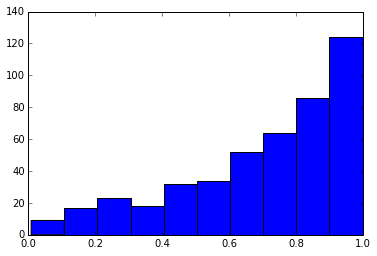

In [16]:
anova_pvalues = []
for j in range(len(Anova_pvalues.items())):
    anova_pvalues += [i[1] for i in Anova_pvalues.items()[j][1].items()]
    
%matplotlib inline
a = plt.hist(anova_pvalues)

### Find the proportion of significant ANOVA results

In [35]:
import numpy as np
np.percentile(anova_pvalues,0.92)

0.050203999999999999

1% of the tests are significant which is less than the expected error

## Ancestral states

In [18]:
# Make a list of TE class and superfamily names,
# which occur in at least 15 species
import cloud.serialization.cloudpickle as pickle
pickle_file_name = 'fit_of_TEs_to_tree/result_dfs.pkl'
pickle_handle = open(pickle_file_name, 'rb')
result_dfs = pickle.pickle.load(pickle_handle)

TEs = sorted([key for key in result_dfs.keys() if
              not 'Unclassified' in key and
              not '?' in key and
              len([r for r in pj.records if any([key in f.qualifiers.keys() for f in r.features])]) > 14 ],
             
             key=lambda n: sum([int(r.features[1].qualifiers[n][0]) for r in pj.records 
                                          if n in r.features[1].qualifiers.keys()]),
             reverse=True
             )        

# Make a results directory
if not os.path.exists('independent_contrasts/anc'):
    os.mkdir('independent_contrasts/anc')

### Pooled ancestral state change
A tree with node sizes representing the median change across all TE superfamilies

In [19]:
# Get the relevant genome codes
expected_codes = TE.genome_codes_list('Genomes/',code_file='genome_assembly_files_v3.csv')
if len(expected_codes) == 0:
    raise IOError('could not read expected codes')
        
for code in ['Eela','Ooch', 'Hbak','Mjav']:
    try:
        expected_codes.remove(code)
    except:
        print "%s not in list"%code

# Make a tree object
master_tree=Tree('independent_contrasts/input.tre')

# For each superfamily:
for e in [k for k in TEs if not k in ['DNA','LTR','LINE','SINE']]:
    
    # Make a dataframe with the superfamily counts
    df = make_df_from_project(pj, 'keep', expected_codes, [e], sep=",", head=True)
    %Rpush df
    E = e.replace('/','.').replace('-','.')
    %Rpush E
    
    # Compute ancestral states for this fuperfamily
    %R Anc <- FASTANC(df, 'independent_contrasts/input.tre', E)
    %R WRITEANCESTORS('independent_contrasts/input.tre', 'temp', Anc, digits=0)
    
    # Make a tree object out of the anotated tree
    anctrestr = open('temp','r').read().replace('&ancstate={','&&NHX:ancstate=').replace('}','')
    t = Tree(anctrestr)
    
    # Add leaf counts
    for l in t:
        from itertools import chain
        for f in chain(*[r.features for r in pj.records]):
            quals = f.qualifiers
            if 'keep' in quals and quals['keep'][0]==l.name:
                if e in quals:
                    l.add_feature('ancstate',quals[e][0])
                else:
                    l.add_feature('ancstate',0)
                    
    # make sure all leaves have ancstate
    # this will put 0 if no attr ancstate
    for n in t.traverse():
        setattr(n, 'ancstate', getattr(n, 'ancstate',0))
    
    # Calculate the change proportion in each node
    for n in t.traverse():
        if not n.is_root():
            count = n.ancstate
            parent_count = n.up.ancstate
            prop=None
            if float(parent_count) < 1.0:
                prop = 1
            else:   
                prop = int(count)/float(parent_count)
            n.add_feature('ancstateprop',prop)
            leaf_names = n.get_leaf_names()
            master_node = None
            if n.is_leaf():
                master_node = master_tree&n.name
            else:
                master_node = master_tree.get_common_ancestor(leaf_names)
            try:
                master_node.ancstateprop.append(prop)
            except:
                master_node.add_feature('ancstateprop', [prop])
    t.write(outfile='independent_contrasts/anc/%s.tre'%E, format=5, features=[])
master_tree.write(outfile='independent_contrasts/anc/master.tre', format=5, features=[])                           

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc1 was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc1 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc1 was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc1 was not found in sample Haor
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc1 was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc1 was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc1 was not found in sample Tspi
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA

### DNA elements ancestral stated
A tree with node sizes representing the median change across all DNA TE superfamilies

In [20]:
# Make a tree object
DNA_tree=Tree('independent_contrasts/input.tre')

# For each superfamily:
for e in [k for k in TEs if 'DNA' in k and not k == 'DNA' and not 'nclassified' in k and not '?' in k]:
    
    # Make a dataframe with the superfamily counts
    df = make_df_from_project(pj, 'keep', expected_codes, [e], sep=",", head=True)
    %Rpush df
    E = e.replace('/','.').replace('-','.')
    %Rpush E
    
    # Compute ancestral states for this fuperfamily
    %R Anc <- FASTANC(df, 'independent_contrasts/input.tre', E)
    %R WRITEANCESTORS('independent_contrasts/input.tre', 'temp', Anc, digits=0)
    
    # Make a tree object out of the anotated tree
    anctrestr = open('temp','r').read().replace('&ancstate={','&&NHX:ancstate=').replace('}','')
    t = Tree(anctrestr)
    
    # Add leaf counts
    for l in t:
        from itertools import chain
        for f in chain(*[r.features for r in pj.records]):
            quals = f.qualifiers
            if 'keep' in quals and quals['keep'][0]==l.name:
                if e in quals:
                    l.add_feature('ancstate',quals[e][0])
                else:
                    l.add_feature('ancstate',0)
                    
    # make sure all leaves have ancstate
    # this will put 0 if no attr ancstate
    for n in t.traverse():
        setattr(n, 'ancstate', getattr(n, 'ancstate',0))
    
    # calculate proportion delta
    for n in t.traverse():
        if not n.is_root():
            count = n.ancstate
            parent_count = n.up.ancstate
            prop=None
            if float(parent_count) == 0:
                prop = 1
            elif float(parent_count) < 0.1 and count > 0.99:
                prop = 1.5
            elif float(parent_count) < 0.1 and count <= 0.99:
                prop = 1
            else:
            #print parent_count    
                prop = int(count)/float(parent_count)
            n.add_feature('ancstateprop',prop)
            leaf_names = n.get_leaf_names()
            master_node = None
            if n.is_leaf():
                master_node = DNA_tree&n.name
            else:
                master_node = DNA_tree.get_common_ancestor(leaf_names)
            try:
                master_node.ancstateprop.append(prop)
            except:
                master_node.add_feature('ancstateprop', [prop])
    t.write(outfile='independent_contrasts/anc/%s.tre'%E, format=5, features=[])
DNA_tree.write(outfile='independent_contrasts/anc/DNA.tre', format=5, features=[])
                            

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc1 was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc1 was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc1 was not found in sample Smur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc1 was not found in sample Haor
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc1 was not found in sample Lsig
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc1 was not found in sample Tmur
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA/TcMar-Tc1 was not found in sample Tspi
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key DNA

### LTR elements ancestral stated
A tree with node sizes representing the median change across all LTR TE superfamilies

In [21]:
# Make a tree object
LTR_tree=Tree('independent_contrasts/input.tre')

# For each superfamily:
for e in [k for k in TEs if 'LTR' in k and not k == 'LTR' and not 'nclassified' in k and not '?' in k]:
    
    # Make a dataframe with the superfamily counts
    df = make_df_from_project(pj, 'keep', expected_codes, [e], sep=",", head=True)
    %Rpush df
    E = e.replace('/','.').replace('-','.')
    %Rpush E
    
    # Compute ancestral states for this fuperfamily
    %R Anc <- FASTANC(df, 'independent_contrasts/input.tre', E)
    %R WRITEANCESTORS('independent_contrasts/input.tre', 'temp', Anc, digits=0)
    
    # Make a tree object out of the anotated tree
    anctrestr = open('temp','r').read().replace('&ancstate={','&&NHX:ancstate=').replace('}','')
    t = Tree(anctrestr)
    
    # Add leaf counts
    for l in t:
        from itertools import chain
        for f in chain(*[r.features for r in pj.records]):
            quals = f.qualifiers
            if 'keep' in quals and quals['keep'][0]==l.name:
                if e in quals:
                    l.add_feature('ancstate',quals[e][0])
                else:
                    l.add_feature('ancstate',0)
                    
    # make sure all leaves have ancstate
    # this will put 0 if no attr ancstate
    for n in t.traverse():
        setattr(n, 'ancstate', getattr(n, 'ancstate',0))
    
    # calculate proportion delta
    for n in t.traverse():
        if not n.is_root():
            count = n.ancstate
            parent_count = n.up.ancstate
            prop=None
            if float(parent_count) == 0:
                prop = 1
            elif float(parent_count) < 0.1 and count > 0.99:
                prop = 1.5
            elif float(parent_count) < 0.1 and count <= 0.99:
                prop = 1
            else:
            #print parent_count    
                prop = int(count)/float(parent_count)
            n.add_feature('ancstateprop',prop)
            leaf_names = n.get_leaf_names()
            master_node = None
            if n.is_leaf():
                master_node = LTR_tree&n.name
            else:
                master_node = LTR_tree.get_common_ancestor(leaf_names)
            try:
                master_node.ancstateprop.append(prop)
            except:
                master_node.add_feature('ancstateprop', [prop])
    t.write(outfile='independent_contrasts/anc/%s.tre'%E, format=5, features=[])
LTR_tree.write(outfile='independent_contrasts/anc/LTR.tre', format=5, features=[])

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/Pao was not found in sample Pcof
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/Roo was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERVK was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERVK was not found in sample Sbat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERVK was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERVK was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERVK was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LTR/ERVK was not found in sample Mflo
/u

### LINE elements ancestral stated
A tree with node sizes representing the median change across all LINE TE superfamilies

In [22]:
# Make a tree object
LINE_tree=Tree('independent_contrasts/input.tre')

# For each superfamily:
for e in [k for k in TEs if 'LINE' in k and not k == 'LINE' and not 'nclassified' in k and not '?' in k]:
    
    # Make a dataframe with the superfamily counts
    df = make_df_from_project(pj, 'keep', expected_codes, [e], sep=",", head=True)
    %Rpush df
    E = e.replace('/','.').replace('-','.')
    %Rpush E
    
    # Compute ancestral states for this fuperfamily
    %R Anc <- FASTANC(df, 'independent_contrasts/input.tre', E)
    %R WRITEANCESTORS('independent_contrasts/input.tre', 'temp', Anc, digits=0)
    
    # Make a tree object out of the anotated tree
    anctrestr = open('temp','r').read().replace('&ancstate={','&&NHX:ancstate=').replace('}','')
    t = Tree(anctrestr)
    
    # Add leaf counts
    for l in t:
        from itertools import chain
        for f in chain(*[r.features for r in pj.records]):
            quals = f.qualifiers
            if 'keep' in quals and quals['keep'][0]==l.name:
                if e in quals:
                    l.add_feature('ancstate',quals[e][0])
                else:
                    l.add_feature('ancstate',0)
                    
    # make sure all leaves have ancstate
    # this will put 0 if no attr ancstate
    for n in t.traverse():
        setattr(n, 'ancstate', getattr(n, 'ancstate',0))
    
    # calculate proportion delta
    for n in t.traverse():
        if not n.is_root():
            count = n.ancstate
            parent_count = n.up.ancstate
            prop=None
            if float(parent_count) == 0:
                prop = 1
            elif  float(parent_count) < 0.1 and count > 0.99:
                prop = 1.5
            elif float(parent_count) < 0.1 and count <= 0.99:
                prop = 1
            else:
            #print parent_count    
                prop = int(count)/float(parent_count)
            n.add_feature('ancstateprop',prop)
            leaf_names = n.get_leaf_names()
            master_node = None
            if n.is_leaf():
                master_node = LINE_tree&n.name
            else:
                master_node = LINE_tree.get_common_ancestor(leaf_names)
            try:
                master_node.ancstateprop.append(prop)
            except:
                master_node.add_feature('ancstateprop', [prop])
    t.write(outfile='independent_contrasts/anc/%s.tre'%E, format=5, features=[])
LINE_tree.write(outfile='independent_contrasts/anc/LINE.tre', format=5, features=[])

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Penelope was not found in sample Btim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Penelope was not found in sample Ever
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Penelope was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Penelope was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Penelope was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Penelope was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Penelope was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LIN

### SINE elements ancestral stated
A tree with node sizes representing the median change across all SINE TE superfamilies

In [23]:
# Make a tree object
SINE_tree=Tree('independent_contrasts/input.tre')

# For each superfamily:
for e in [k for k in TEs if 'LINE' in k and not k == 'SINE' and not 'nclassified' in k and not '?' in k]:
    
    # Make a dataframe with the superfamily counts
    df = make_df_from_project(pj, 'keep', expected_codes, [e], sep=",", head=True)
    %Rpush df
    E = e.replace('/','.').replace('-','.')
    %Rpush E
    %R Anc <- FASTANC(df, 'independent_contrasts/input.tre', E)
    %R WRITEANCESTORS('independent_contrasts/input.tre', 'temp', Anc, digits=0)
    
    # Make a tree object out of the anotated tree
    anctrestr = open('temp','r').read().replace('&ancstate={','&&NHX:ancstate=').replace('}','')
    t = Tree(anctrestr)
    
    # Add leaf counts
    for l in t:
        from itertools import chain
        for f in chain(*[r.features for r in pj.records]):
            quals = f.qualifiers
            if 'keep' in quals and quals['keep'][0]==l.name:
                if e in quals:
                    l.add_feature('ancstate',quals[e][0])
                else:
                    l.add_feature('ancstate',0)
                    
    # make sure all leaves have ancstate
    # this will put 0 if no attr ancstate
    for n in t.traverse():
        setattr(n, 'ancstate', getattr(n, 'ancstate',0))
    
    # calculate proportion delta
    for n in t.traverse():
        if not n.is_root():
            count = n.ancstate
            parent_count = n.up.ancstate
            prop=None
            if float(parent_count) == 0:
                prop = 1
            elif  float(parent_count) < 0.1 and count > 0.99:
                prop = 1.5
            elif float(parent_count) < 0.1 and count <= 0.99:
                prop = 1
            else:
            #print parent_count    
                prop = int(count)/float(parent_count)
            n.add_feature('ancstateprop',prop)
            leaf_names = n.get_leaf_names()
            master_node = None
            if n.is_leaf():
                master_node = SINE_tree&n.name
            else:
                master_node = SINE_tree.get_common_ancestor(leaf_names)
            try:
                master_node.ancstateprop.append(prop)
            except:
                master_node.add_feature('ancstateprop', [prop])
    t.write(outfile='independent_contrasts/anc/%s.tre'%E, format=5, features=[])
SINE_tree.write(outfile='independent_contrasts/anc/SINE.tre', format=5, features=[])

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Penelope was not found in sample Btim
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Penelope was not found in sample Ever
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Penelope was not found in sample Ptri
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Penelope was not found in sample Spap
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Penelope was not found in sample Srat
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Penelope was not found in sample Sven
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LINE/Penelope was not found in sample Wban
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:40: UserWarning: key LIN

## Figure 4
## Fig 4A

returning records list of locus 18S and filter [['keep', 'Hduj']]
returning records list of locus 18S and filter [['keep', 'Ebre']]
returning records list of locus 18S and filter [['keep', 'Rcul']]
returning records list of locus 18S and filter [['keep', 'Sbat']]
returning records list of locus 18S and filter [['keep', 'Tspi']]
returning records list of locus 18S and filter [['keep', 'Smur']]
returning records list of locus 18S and filter [['keep', 'Ever']]
returning records list of locus 18S and filter [['keep', 'Ppac']]
returning records list of locus 18S and filter [['keep', 'Tmur']]
returning records list of locus 18S and filter [['keep', 'Ttri']]
returning records list of locus 18S and filter [['keep', 'Asim']]
returning records list of locus 18S and filter [['keep', 'Pred']]
returning records list of locus 18S and filter [['keep', 'Haor']]
returning records list of locus 18S and filter [['keep', 'Tcan']]
returning records list of locus 18S and filter [['keep', 'Asuu']]
returning 

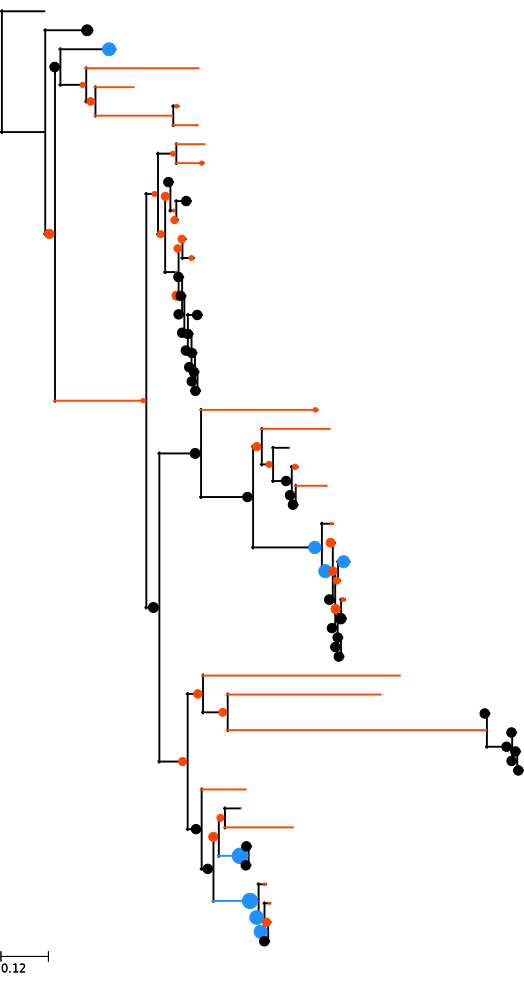

In [24]:
ts = TreeStyle()
ts.scale = 400
ts.min_leaf_separation = 20
ts.show_leaf_name = False

for n in DNA_tree.traverse():
    ns = NodeStyle()
    ns['size'] = 0
    ns['fgcolor']='white'
    ns['hz_line_width']=2
    ns['vt_line_width']=2
    n.set_style(ns)
    if not n.is_root() and not n.up.is_root():# and not n.is_leaf():
        m = np.median(n.ancstateprop)
        color = 'black'
        if m > 1.2:
            color = 'DodgerBlue'
        elif m < 0.98:
            color = 'OrangeRed'
        face = CircleFace(m*5, color)
        pos = 'float'
        n.add_face(face,0,pos)
        if n.dist > 0.06 and m > 1.5:
            ns['hz_line_color'] = 'DodgerBlue'
        elif n.dist > 0.06 and m < 0.5:
            ns['hz_line_color'] = 'OrangeRed'
    if n.is_leaf():
        pos='aligned'
        f_id = pj.fr('18S', filter=[['keep',n.name]])[0].id
        orgn = get_qualifiers_dictionary(pj,f_id)['source_organism']
        #.add_face(TextFace(orgn), 0,'branch-right')
DNA_tree.render('%%inline', h=1000, tree_style=ts)

### Fig 4B

returning records list of locus 18S and filter [['keep', 'Hduj']]
returning records list of locus 18S and filter [['keep', 'Ebre']]
returning records list of locus 18S and filter [['keep', 'Rcul']]
returning records list of locus 18S and filter [['keep', 'Sbat']]
returning records list of locus 18S and filter [['keep', 'Tspi']]
returning records list of locus 18S and filter [['keep', 'Smur']]
returning records list of locus 18S and filter [['keep', 'Ever']]
returning records list of locus 18S and filter [['keep', 'Ppac']]
returning records list of locus 18S and filter [['keep', 'Tmur']]
returning records list of locus 18S and filter [['keep', 'Ttri']]
returning records list of locus 18S and filter [['keep', 'Asim']]
returning records list of locus 18S and filter [['keep', 'Pred']]
returning records list of locus 18S and filter [['keep', 'Haor']]
returning records list of locus 18S and filter [['keep', 'Tcan']]
returning records list of locus 18S and filter [['keep', 'Asuu']]
returning 

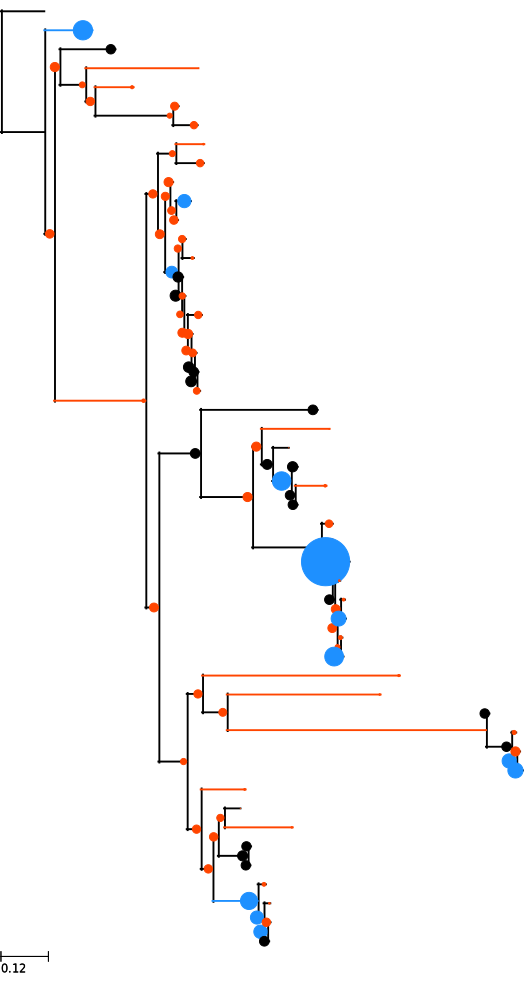

In [25]:
ts = TreeStyle()
ts.scale = 400
ts.show_leaf_name = False
ts.min_leaf_separation = 20
for n in LTR_tree.traverse():
    ns = NodeStyle()
    ns['size'] = 0
    ns['fgcolor']='white'
    ns['hz_line_width']=2
    ns['vt_line_width']=2
    n.set_style(ns)
    if not n.is_root() and not n.up.is_root():# and not n.is_leaf():
        m = np.median(n.ancstateprop)
        color = 'black'
        if m > 1.2:
            color = 'DodgerBlue'
        elif m < 0.98:
            color = 'OrangeRed'
        face = CircleFace(m*5, color)
        pos = 'float'
        n.add_face(face,0,pos)
        if n.dist > 0.06 and m > 1.5:
            ns['hz_line_color'] = 'DodgerBlue'
        elif n.dist > 0.06 and m < 0.5:
            ns['hz_line_color'] = 'OrangeRed'
    if n.is_leaf():
        pos='aligned'
        f_id = pj.fr('18S', filter=[['keep',n.name]])[0].id
        orgn = get_qualifiers_dictionary(pj,f_id)['source_organism']
        #n.add_face(TextFace(orgn), 0,'branch-right')
LTR_tree.render('%%inline', h=1000, tree_style=ts)

###Fig 4C

returning records list of locus 18S and filter [['keep', 'Hduj']]
returning records list of locus 18S and filter [['keep', 'Ebre']]
returning records list of locus 18S and filter [['keep', 'Rcul']]
returning records list of locus 18S and filter [['keep', 'Sbat']]
returning records list of locus 18S and filter [['keep', 'Tspi']]
returning records list of locus 18S and filter [['keep', 'Smur']]
returning records list of locus 18S and filter [['keep', 'Ever']]
returning records list of locus 18S and filter [['keep', 'Ppac']]
returning records list of locus 18S and filter [['keep', 'Tmur']]
returning records list of locus 18S and filter [['keep', 'Ttri']]
returning records list of locus 18S and filter [['keep', 'Asim']]
returning records list of locus 18S and filter [['keep', 'Pred']]
returning records list of locus 18S and filter [['keep', 'Haor']]
returning records list of locus 18S and filter [['keep', 'Tcan']]
returning records list of locus 18S and filter [['keep', 'Asuu']]
returning 

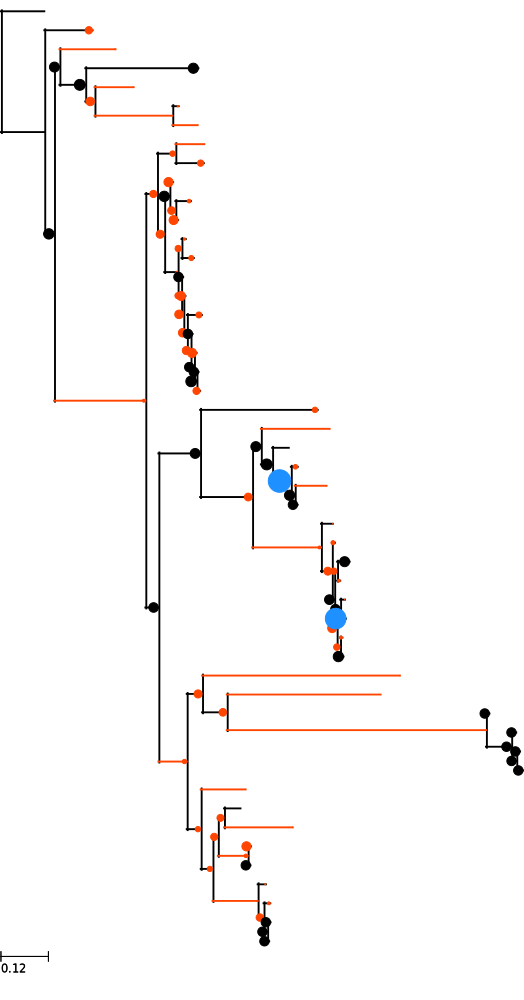

In [26]:
ts = TreeStyle()
ts.scale = 400
ts.min_leaf_separation = 20
ts.show_leaf_name = False
for n in LINE_tree.traverse():
    ns = NodeStyle()
    ns['size'] = 0
    ns['fgcolor']='white'
    ns['hz_line_width']=2
    ns['vt_line_width']=2
    n.set_style(ns)
    if not n.is_root() and not n.up.is_root():# and not n.is_leaf():
        m = np.median(n.ancstateprop)
        color = 'black'
        if m > 1.2:
            color = 'DodgerBlue'
        elif m < 0.98:
            color = 'OrangeRed'
        face = CircleFace(m*5, color)
        pos = 'float'
        n.add_face(face,0,pos)
        if n.dist > 0.06 and m > 1.5:
            ns['hz_line_color'] = 'DodgerBlue'
        elif n.dist > 0.06 and m < 0.5:
            ns['hz_line_color'] = 'OrangeRed'
    if n.is_leaf():
        pos='aligned'
        f_id = pj.fr('18S', filter=[['keep',n.name]])[0].id
        orgn = get_qualifiers_dictionary(pj,f_id)['source_organism']
        #n.add_face(TextFace(orgn), 0,'branch-right')
LINE_tree.render('%%inline', h=1000, tree_style=ts)


### Fig 4D

returning records list of locus 18S and filter [['keep', 'Hduj']]
returning records list of locus 18S and filter [['keep', 'Ebre']]
returning records list of locus 18S and filter [['keep', 'Rcul']]
returning records list of locus 18S and filter [['keep', 'Sbat']]
returning records list of locus 18S and filter [['keep', 'Tspi']]
returning records list of locus 18S and filter [['keep', 'Smur']]
returning records list of locus 18S and filter [['keep', 'Ever']]
returning records list of locus 18S and filter [['keep', 'Ppac']]
returning records list of locus 18S and filter [['keep', 'Tmur']]
returning records list of locus 18S and filter [['keep', 'Ttri']]
returning records list of locus 18S and filter [['keep', 'Asim']]
returning records list of locus 18S and filter [['keep', 'Pred']]
returning records list of locus 18S and filter [['keep', 'Haor']]
returning records list of locus 18S and filter [['keep', 'Tcan']]
returning records list of locus 18S and filter [['keep', 'Asuu']]
returning 

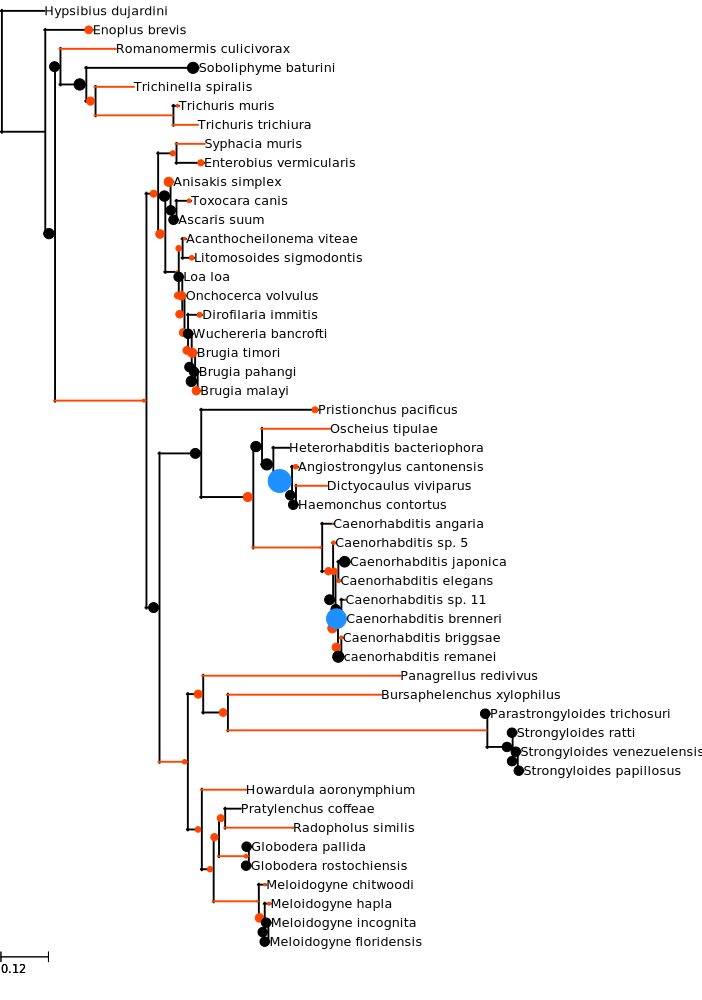

In [27]:
ts = TreeStyle()
ts.scale = 400
ts.min_leaf_separation = 20
ts.show_leaf_name = False
for n in SINE_tree.traverse():
    ns = NodeStyle()
    ns['size'] = 0
    ns['fgcolor']='white'
    ns['hz_line_width']=2
    ns['vt_line_width']=2
    n.set_style(ns)
    if not n.is_root() and not n.up.is_root():# and not n.is_leaf():
        m = np.median(n.ancstateprop)
        color = 'black'
        if m > 1.2:
            color = 'DodgerBlue'
        elif m < 0.98:
            color = 'OrangeRed'
        face = CircleFace(m*5, color)
        pos = 'float'
        n.add_face(face,0,pos)
        if n.dist > 0.06 and m > 1.5:
            ns['hz_line_color'] = 'DodgerBlue'
        elif n.dist > 0.06 and m < 0.5:
            ns['hz_line_color'] = 'OrangeRed'
    if n.is_leaf():
        pos='aligned'
        f_id = pj.fr('18S', filter=[['keep',n.name]])[0].id
        orgn = get_qualifiers_dictionary(pj,f_id)['source_organism']
        n.add_face(TextFace(orgn), 0,'branch-right')
SINE_tree.render('%%inline', h=1000, tree_style=ts)

### Write figure files

In [28]:
ts = TreeStyle()
ts.scale = 300
ts.min_leaf_separation = 20
ts.show_leaf_name = False

DNA_tree.render('independent_contrasts/anc/DNA_tree_anc_change.png', h=1000, tree_style=ts)
LTR_tree.render('independent_contrasts/anc/LTR_anc_change.png', h=1000, tree_style=ts)
LINE_tree.render('independent_contrasts/anc/LINE_anc_change.png', h=1000, tree_style=ts)
ts.scale = 200
SINE_tree.render('independent_contrasts/anc/SINE_anc_change.png', h=1000, tree_style=ts)

{'faces': [[229.10779467680607,
   496.67300380228136,
   376.44619771863114,
   512.8326996197719,
   54,
   'Haemonchus contortus'],
  [185.6783269961977,
   800.8555133079848,
   318.75817490494296,
   817.0152091254753,
   87,
   'Pratylenchus coffeae'],
  [254.10190114068442,
   515.6844106463878,
   401.4403041825095,
   531.8441064638783,
   56,
   'Caenorhabditis angaria'],
  [155.60218631178705,
   363.5931558935361,
   251.6097908745247,
   379.7528517110266,
   40,
   'Brugia pahangi'],
  [208.07395437262358,
   895.9125475285172,
   327.8458174904943,
   912.0722433460077,
   95,
   'Meloidogyne hapla'],
  [208.7725285171103,
   914.9239543726236,
   352.30865019011407,
   931.0836501901141,
   97,
   'Meloidogyne incognita'],
  [207.72110266159697,
   933.93536121673,
   356.9606463878327,
   950.0950570342205,
   98,
   'Meloidogyne floridensis'],
  [193.21283269961978,
   857.8897338403042,
   346.2546577946768,
   874.0494296577947,
   91,
   'Globodera rostochiensis'],

## Write S1 Results

In [29]:
!rm -r independent_contrasts/project_reprot independent_contrasts/project_reprot.zip

rm: cannot remove ‘independent_contrasts/project_reprot’: No such file or directory


In [30]:
from reprophylo import *
pj = unpickle_pj('independent_contrasts/18S_tree_reprophylo_project_with_TE_style_and_RNAi', git=False)
publish(pj, 'independent_contrasts/project_reprot', '.')

checking if file exists
reporter was called by publish
starting species table
starting concatenations
starting methods
starting alignment statistics
starting RF matrix(ces)
reporting trees
pickling
archiving
report ready
